# <span style="color:red"> Main Modelling - Random Forest, Bagging and Boosting - Gridsearch </span>
* read in pickle
* keep 3 translators
* final selected features based on initial analysis with logistic regression
* drop 'A Wild Sheep Chase' due to unique text
* run random forest grid search with initial analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textacy
import re
import pickle
import os

from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, classification_report, average_precision_score, roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import label_binarize

from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn import datasets

from xgboost import XGBClassifier

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# import class to run modelling steps
from translator_modelling import Modelling

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# extend limit of number of rows and columns to display in cell
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100


Bad key "text.kerning_factor" on line 4 in
/Users/Steven/opt/anaconda3/envs/textacy/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


### Load the dataframe containing text chunks and related variables

In [2]:
in_full_path = '../../../../Documents/murakami/pkl3/df_all_v02.pkl'
# read back pickle
with open (in_full_path, 'rb') as fp:
    df = pickle.load(fp)

### Check the dataframe is as expected

In [3]:
df.head(1)

,book_chunk_no,number,title,text,fstop_indices,split_indices,chunks,translator,book_title,parsed,n_sents,n_words,n_chars,n_syllables,n_unique_words,n_long_words,n_monosyllable_words,n_polysyllable_words,trans_code,chunk_length,n_sents_norm,n_words_norm,n_chars_norm,n_syllables_norm,n_unique_words_norm,n_long_words_norm,n_monosyllable_words_norm,n_polysyllable_words_norm,vader_compound,vader_neg,vader_neu,vader_pos,pron_count,verb_count,det_count,adj_count,num_count,punct_count,noun_count,adp_count,cconj_count,sconj_count,adv_count,aux_count,part_count,propn_count,space_count,intj_count,sym_count,x_count,...,then_adv,more_adv,even_adv,why_adv,maybe_adv,again_adv,now_adv,just_adv,how_adv,where_adv,very_adv,only_adv,there_adv,still_adv,so_adv,too_adv,when_adv,all_adv,here_adv,never_adv,as_adv,new_adj,other_adj,more_adj,small_adj,deep_adj,whole_adj,first_adj,bad_adj,little_adj,next_adj,much_adj,own_adj,hard_adj,last_adj,only_adj,big_adj,right_adj,long_adj,old_adj,strange_adj,same_adj,young_adj,sure_adj,able_adj,real_adj,different_adj,good_adj,few_adj,vlong_words_count
0,0,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",IT WAS A short one-paragraph item in the morni...,Alfred Birnbaum,A Wild Sheep Chase,"(IT, WAS, A, short, one, -, paragraph, item, i...",15,174,742,240,116,33,128,17,0,944,15.889831,184.322034,786.016949,254.237288,122.881356,34.957627,135.59322,18.008475,-0.4798,0.075,0.862,0.064,18.0,20.0,31.0,9.0,2.0,33.0,51.0,19.0,6.0,3.0,5.0,5.0,3.0,2.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [4]:
df.shape

(5212, 142)

### Check the baseline

In [5]:
baseline_acc = df['trans_code'].value_counts(normalize=True).max()
baseline_acc

0.39927091327705294

## Random Forest classification with grid search

In [6]:
# prepare modelling
model = RandomForestClassifier(max_depth=2)
rfc = Modelling(df, model)

# select feature groups for modelling
predictor_cols = rfc.feature_select(basic_counts=True, vader=False, pos_counts=True, 
                   words=True, adv=True, adj=True)

# drop some individual features eg. those potentially related to page formatting
cols_to_drop = ['num_count_norm', 'punct_count_norm','space_count_norm', 'sym_count_norm', 'x_count_norm']
predictor_cols = rfc.drop_features(predictor_cols, cols_to_drop)

# prep data i.e. set X and y, train/test split, normalise predictor variables
X_train, X_test, y_train, y_test, idx_train, idx_test = rfc.modelling_prep(predictor_cols, 'trans_code')

# gridsearch model parameters, score fitted model
params = {
            'max_depth': [2,3,5,7,9,11],
            'n_estimators': [20, 50, 100, 200, 300],
            'min_samples_split' : [2, 5, 10],
            'min_samples_leaf' : [1, 2, 5, 10]
            }

# lreg_gs_01 = lr.gridsearch(model, params, X_train, y_train)
rfc.gridsearch(params, X_train, y_train)

# score the fitted model
rfc_gs_01_results = rfc.gridsearch_score(X_train, y_train, X_test, y_test)

# save fitted model
out_path = '../../../../Documents/murakami/pkl_models/'
out_name = 'rfc_gs_01'
out_full_path = out_path + out_name + '.pkl'
rfc.save_model(out_full_path)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   12.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   53.3s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  2.1min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  3.8min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  6.7min
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed: 12.2min
[Parallel(n_jobs=2)]: Done 1800 out of 1800 | elapsed: 12.3min finished


Best Parameters:
{'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Best estimator mean cross validated training score:
0.6533940194782948
Best estimator score on the full training set:
0.9815303430079155
Best estimator score on the test set:
0.6682646212847555
ROC-AUC score on the test set:
Class 0: 0.81
Class 1: 0.85
Class 2: 0.88


#### RF does not do as well as logistic regression or KNN or even DT for the moment

### Confusion Matrix

In [7]:
print(pd.DataFrame(rfc_gs_01_results['conmat'], index=['actual birnbaum', 'actual rubin', 'actual gabriel'],
                             columns=['predicted birnbaum', 'predicted rubin', 'predicted gabriel']))

                 predicted birnbaum  predicted rubin  predicted gabriel
actual birnbaum                 231               94                 20
actual rubin                     67              333                 16
actual gabriel                   80               69                133


### Classification Report

In [8]:
# print(classification_report(y_test, predictions))

In [9]:
rfc.model_gs.best_estimator_.feature_importances_

array([0.06145313, 0.02585498, 0.02697081, 0.02167851, 0.04220614,
       0.0229237 , 0.02464648, 0.02063392, 0.02797034, 0.02431416,
       0.0228714 , 0.02158072, 0.03103672, 0.02331022, 0.0262627 ,
       0.0217737 , 0.03516723, 0.03433456, 0.02082564, 0.03459627,
       0.02078622, 0.01611045, 0.01567367, 0.01305639, 0.01074926,
       0.01406906, 0.01950132, 0.03556748, 0.012324  , 0.05063099,
       0.01707447, 0.00852101, 0.00437582, 0.00524293, 0.00451273,
       0.00336552, 0.0078558 , 0.00595331, 0.00202502, 0.00328815,
       0.00212255, 0.00215112, 0.00207234, 0.00326309, 0.00181333,
       0.00211694, 0.00456691, 0.00162415, 0.00234789, 0.00222893,
       0.00224836, 0.00165362, 0.0017901 , 0.00227412, 0.00349769,
       0.00319898, 0.0035367 , 0.00213069, 0.00291696, 0.00226226,
       0.00256643, 0.00270516, 0.0018572 , 0.00214363, 0.00314392,
       0.00245482, 0.00308458, 0.00490019, 0.00283538, 0.00708967,
       0.00266482, 0.00390015, 0.00291266, 0.00406852, 0.00262

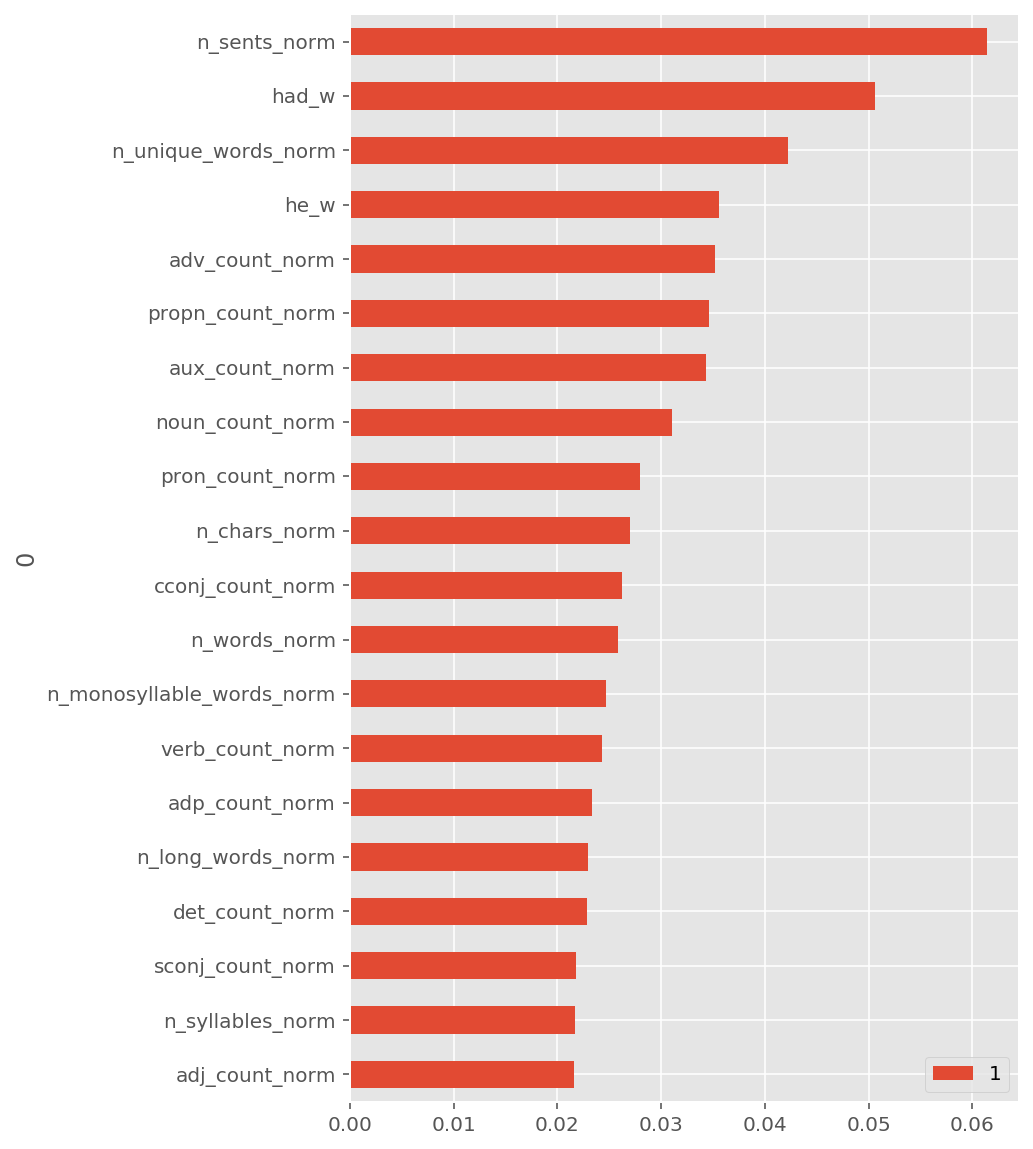

In [10]:
pd.DataFrame(list(zip(X_train.columns,rfc.model_gs.best_estimator_.feature_importances_))) \
                    .sort_values(by=1,ascending=True).tail(20).plot(kind='barh', x=0,y=1,figsize=(6,10))
plt.show()

### Bagging with Decision Tree and gridsearch

In [11]:
# prepare modelling
model = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=None), n_estimators=300)
bg_dt = Modelling(df, model)

# select feature groups for modelling
predictor_cols = bg_dt.feature_select(basic_counts=True, vader=False, pos_counts=True, 
                   words=True, adv=True, adj=True)

# drop some individual features eg. those potentially related to page formatting
cols_to_drop = ['num_count_norm', 'punct_count_norm','space_count_norm', 'sym_count_norm', 'x_count_norm']
predictor_cols = bg_dt.drop_features(predictor_cols, cols_to_drop)

# prep data i.e. set X and y, train/test split, normalise predictor variables
X_train, X_test, y_train, y_test, idx_train, idx_test = bg_dt.modelling_prep(predictor_cols, 'trans_code')

# gridsearch model parameters, score fitted model
params = {'n_estimators': [100, 200, 300],
          'max_samples': [0.5, 0.8],
          'max_features': [0.5, 0.8]}

bg_dt.gridsearch(params, X_train, y_train)

# score the fitted model
bg_dt_gs_01_results = bg_dt.gridsearch_score(X_train, y_train, X_test, y_test)

# save fitted model
out_path = '../../../../Documents/murakami/pkl_models/'
out_name = 'bg_dt_gs_01'
out_full_path = out_path + out_name + '.pkl'
bg_dt.save_model(out_full_path)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  2.4min
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:  3.6min finished


Best Parameters:
{'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 200}
Best estimator mean cross validated training score:
0.660587400427797
Best estimator score on the full training set:
1.0
Best estimator score on the test set:
0.6788111217641419
ROC-AUC score on the test set:
Class 0: 0.82
Class 1: 0.85
Class 2: 0.88


### Confusion Matrix

In [12]:
print(pd.DataFrame(bg_dt_gs_01_results['conmat'], index=['actual birnbaum', 'actual rubin', 'actual gabriel'],
                             columns=['predicted birnbaum', 'predicted rubin', 'predicted gabriel']))

                 predicted birnbaum  predicted rubin  predicted gabriel
actual birnbaum                 219               96                 30
actual rubin                     66              322                 28
actual gabriel                   59               56                167


Very slight improvement for bagging with dt and with gridsearch not significant 

### Bagging with KNN

In [13]:
# prepare modelling
model = BaggingClassifier(base_estimator=KNeighborsClassifier(), n_estimators=300)
bg_knn = Modelling(df, model)

# select feature groups for modelling
predictor_cols = bg_knn.feature_select(basic_counts=True, vader=False, pos_counts=True, 
                   words=True, adv=True, adj=True)

# drop some individual features eg. those potentially related to page formatting
cols_to_drop = ['num_count_norm', 'punct_count_norm','space_count_norm', 'sym_count_norm', 'x_count_norm']
predictor_cols = bg_knn.drop_features(predictor_cols, cols_to_drop)

# prep data i.e. set X and y, train/test split, normalise predictor variables
X_train, X_test, y_train, y_test, idx_train, idx_test = bg_knn.modelling_prep(predictor_cols, 'trans_code')

# gridsearch model parameters, score fitted model
params = {'n_estimators': [100, 200, 300],
          'max_samples': [0.5, 0.8],
          'max_features': [0.5, 0.8]}

bg_knn.gridsearch(params, X_train, y_train)

# score the fitted model
bg_knn_gs_01_results = bg_knn.gridsearch_score(X_train, y_train, X_test, y_test)

# save fitted model
out_path = '../../../../Documents/murakami/pkl_models/'
out_name = 'bg_knn_gs_01'
out_full_path = out_path + out_name + '.pkl'
bg_knn.save_model(out_full_path)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 43.9min
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed: 72.4min finished


Best Parameters:
{'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 300}
Best estimator mean cross validated training score:
0.5725550651915443
Best estimator score on the full training set:
0.7977932357879587
Best estimator score on the test set:
0.6116970278044104
ROC-AUC score on the test set:
Class 0: 0.79
Class 1: 0.82
Class 2: 0.83


### Confusion Matrix

In [14]:
print(pd.DataFrame(bg_knn_gs_01_results['conmat'], index=['actual birnbaum', 'actual rubin', 'actual gabriel'],
                             columns=['predicted birnbaum', 'predicted rubin', 'predicted gabriel']))

                 predicted birnbaum  predicted rubin  predicted gabriel
actual birnbaum                 210              119                 16
actual rubin                     67              340                  9
actual gabriel                   78              116                 88


### Classification Report

In [15]:
# print(classification_report(y_test, predictions))

### Adaboosting classification with cross validation

In [17]:
# prepare modelling
dt = DecisionTreeClassifier(max_depth=3, max_features = "auto")
model = AdaBoostClassifier(base_estimator=dt, n_estimators=100, random_state=1)
bs_dt = Modelling(df, model)

# select feature groups for modelling
predictor_cols = bs_dt.feature_select(basic_counts=True, vader=False, pos_counts=True, 
                   words=True, adv=True, adj=True)

# drop some individual features eg. those potentially related to page formatting
cols_to_drop = ['num_count_norm', 'punct_count_norm','space_count_norm', 'sym_count_norm', 'x_count_norm']
predictor_cols = bs_dt.drop_features(predictor_cols, cols_to_drop)

# prep data i.e. set X and y, train/test split, normalise predictor variables
X_train, X_test, y_train, y_test, idx_train, idx_test = bs_dt.modelling_prep(predictor_cols, 'trans_code')

# gridsearch model parameters, score fitted model
params = {'n_estimators': [100, 200, 300],
          'learning_rate': [0.001, 0.01, 0.1, 1],
          'base_estimator__max_depth' : [2,3,4,5]}

bs_dt.gridsearch(params, X_train, y_train)

# score the fitted model
bs_dt_gs_01_results = bs_dt.gridsearch_score(X_train, y_train, X_test, y_test)

# save fitted model
out_path = '../../../../Documents/murakami/pkl_models/'
out_name = 'bs_dt_gs_01'
out_full_path = out_path + out_name + '.pkl'
bs_dt.save_model(out_full_path)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   34.8s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  3.2min
[Parallel(n_jobs=2)]: Done 240 out of 240 | elapsed:  4.2min finished


Best Parameters:
{'base_estimator__max_depth': 2, 'learning_rate': 0.1, 'n_estimators': 300}
Best estimator mean cross validated training score:
0.6476377601400272
Best estimator score on the full training set:
0.7335092348284961
Best estimator score on the test set:
0.663470757430489
ROC-AUC score on the test set:
Class 0: 0.8
Class 1: 0.83
Class 2: 0.8


#### ada boost with dt is not great for the moment

### Confusion Matrix

In [18]:
print(pd.DataFrame(bs_dt_gs_01_results['conmat'], index=['actual birnbaum', 'actual rubin', 'actual gabriel'],
                             columns=['predicted birnbaum', 'predicted rubin', 'predicted gabriel']))

                 predicted birnbaum  predicted rubin  predicted gabriel
actual birnbaum                 238               70                 37
actual rubin                     62              313                 41
actual gabriel                   75               66                141


* OK results

### Classification Report

In [19]:
print(classification_report(y_test, ds_dt.model_gs.predict(X_test)))

### Try Gradient Boost with Gridsearch

In [22]:
# prepare modelling
model = GradientBoostingClassifier(criterion='mse', random_state=1)
gb = Modelling(df, model)

# select feature groups for modelling
predictor_cols = gb.feature_select(basic_counts=True, vader=False, pos_counts=True, 
                   words=True, adv=True, adj=True)

# drop some individual features eg. those potentially related to page formatting
cols_to_drop = ['num_count_norm', 'punct_count_norm','space_count_norm', 'sym_count_norm', 'x_count_norm']
predictor_cols = gb.drop_features(predictor_cols, cols_to_drop)

# prep data i.e. set X and y, train/test split, normalise predictor variables
X_train, X_test, y_train, y_test, idx_train, idx_test = gb.modelling_prep(predictor_cols, 'trans_code')

# gridsearch model parameters, score fitted model

params = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.1, 0.2],
#     "min_samples_split": [0.1, 0.25, 0.5],
#     "min_samples_leaf": [0.1, 0.25, 0.5],
    "max_depth":[3,5],
#     "max_features":["log2","sqrt"],
#     "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.75, 1.0],
    "n_estimators":[100, 200]
    }

gb.gridsearch(params, X_train, y_train)

# score the fitted model
gb_gs_01_results = gb.gridsearch_score(X_train, y_train, X_test, y_test)

# save fitted model
out_path = '../../../../Documents/murakami/pkl_models/'
out_name = 'gb_gs_01'
out_full_path = out_path + out_name + '.pkl'
gb.save_model(out_full_path)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  3.6min
[Parallel(n_jobs=2)]: Done 180 out of 180 | elapsed: 18.3min finished


Best Parameters:
{'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.75}
Best estimator mean cross validated training score:
0.6872109995077167
Best estimator score on the full training set:
0.9990405372991125
Best estimator score on the test set:
0.697986577181208
ROC-AUC score on the test set:
Class 0: 0.85
Class 1: 0.87
Class 2: 0.9


### Confusion Matrix

In [23]:
print(pd.DataFrame(gb_gs_01_results['conmat'], index=['actual birnbaum', 'actual rubin', 'actual gabriel'],
                             columns=['predicted birnbaum', 'predicted rubin', 'predicted gabriel']))

                 predicted birnbaum  predicted rubin  predicted gabriel
actual birnbaum                 232               78                 35
actual rubin                     69              315                 32
actual gabriel                   54               47                181


In [24]:
gb.model_gs.best_params_

{'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 5,
 'n_estimators': 200,
 'subsample': 0.75}

### Classification Report

In [25]:
print(classification_report(y_test, gb.model_gs.predict(X_test)))

              precision    recall  f1-score   support

           0       0.65      0.67      0.66       345
           1       0.72      0.76      0.74       416
           2       0.73      0.64      0.68       282

    accuracy                           0.70      1043
   macro avg       0.70      0.69      0.69      1043
weighted avg       0.70      0.70      0.70      1043



### XG boosting classification with grid search

In [26]:
# prepare modelling
model = XGBClassifier()
xgb = Modelling(df, model)

# select feature groups for modelling
predictor_cols = xgb.feature_select(basic_counts=True, vader=False, pos_counts=True, 
                   words=True, adv=True, adj=True)

# drop some individual features eg. those potentially related to page formatting
cols_to_drop = ['num_count_norm', 'punct_count_norm','space_count_norm', 'sym_count_norm', 'x_count_norm']
predictor_cols = xgb.drop_features(predictor_cols, cols_to_drop)

# prep data i.e. set X and y, train/test split, normalise predictor variables
X_train, X_test, y_train, y_test, idx_train, idx_test = xgb.modelling_prep(predictor_cols, 'trans_code')

# gridsearch model parameters, score fitted model
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['multi:softmax','binary:logistic'],
              'learning_rate': [0.01, 0.05, 0.1], #so called `eta` value
              'max_depth': [5,6,7],
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [1000], #number of trees, change it to 1000 for better results
              'missing':[-999],
              'seed': [1337]}

xgb.gridsearch(params, X_train, y_train)

# score the fitted model
xgb_gs_01_results = xgb.gridsearch_score(X_train, y_train, X_test, y_test)

# save fitted model
out_path = '../../../../Documents/murakami/pkl_models/'
out_name = 'xgb_gs_01'
out_full_path = out_path + out_name + '.pkl'
xgb.save_model(out_full_path)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  2.3min
[Parallel(n_jobs=2)]: Done 180 out of 180 | elapsed: 10.0min finished


Best Parameters:
{'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.5}
Best estimator mean cross validated training score:
0.6908115764291328
Best estimator score on the full training set:
0.9836891340849124
Best estimator score on the test set:
0.7085330776605945
ROC-AUC score on the test set:
Class 0: 0.86
Class 1: 0.88
Class 2: 0.9


### Confusion Matrix

In [27]:
print(pd.DataFrame(xgb_gs_01_results['conmat'], index=['actual birnbaum', 'actual rubin', 'actual gabriel'],
                             columns=['predicted birnbaum', 'predicted rubin', 'predicted gabriel']))

                 predicted birnbaum  predicted rubin  predicted gabriel
actual birnbaum                 239               74                 32
actual rubin                     64              315                 37
actual gabriel                   49               48                185


* OK results

### Classification Report

In [28]:
print(classification_report(y_test, xgb.model_gs.predict(X_test)))

              precision    recall  f1-score   support

           0       0.68      0.69      0.69       345
           1       0.72      0.76      0.74       416
           2       0.73      0.66      0.69       282

    accuracy                           0.71      1043
   macro avg       0.71      0.70      0.70      1043
weighted avg       0.71      0.71      0.71      1043

